In [26]:
%matplotlib inline
import numpy as np
import pandas as pd
import lime
import lime.lime_tabular
import shap
import time
import sys
sys.path.append('../../wrapper')
import xgboost
from xgboost import XGBClassifier
from collections import Counter

import os
import glob
import mglearn
import sklearn
import sklearn.datasets

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectPercentile

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, cohen_kappa_score, classification_report
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn import pipeline
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

from string import ascii_letters
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print ('[%s]' % self.name)
        print ('Elapsed: %s' % (time.time() - self.tstart))

In [3]:
def read_files(name):
    path ='/Users/lillian/Documents/graduation_project/datasets/data_anoniem' # use your path
    all_files = glob.glob(os.path.join(path, '*'+name+'.csv'))
    print('*'+name+'.csv')
    frame = pd.DataFrame()
    df = pd.concat((pd.read_csv(f) for f in all_files)).reset_index(drop=True)
    return df

In [4]:
df_train_all = read_files('train')
df_test_all = read_files('test')
df_valid_all = read_files('valid-this')

*train.csv
*test.csv
*valid-this.csv


In [103]:
# path ='/Users/lillian/Documents/graduation_project/datasets/data_anoniem'
# df_train = pd.read_csv(path + '/2017Q3_train.csv')
# df_test = pd.read_csv(path + '/2017Q3_test.csv')
# df_valid = pd.read_csv(path + '/2017Q3_valid-this.csv')
# df_valid_next = pd.read_csv(path + '/2017Q3_valid-next.csv')

In [5]:
le = preprocessing.LabelEncoder()
le.fit(df_train_all.fraud_class)
print(list(le.classes_))

df_train_all['fraud_label'] = le.transform(df_train_all.fraud_class).astype(int)
df_test_all['fraud_label'] = le.transform(df_test_all.fraud_class).astype(int)
df_valid_all['fraud_label'] = le.transform(df_valid_all.fraud_class).astype(int)

['Mo0', 'Mo1', 'Mo2', 'Mo3', 'Mo9']


In [6]:
df_train_all["fraud_label"].value_counts()

0    597593
1      1236
2      1149
3        62
4        51
Name: fraud_label, dtype: int64

In [7]:
df_test_all["fraud_label"].value_counts()

0    597573
1       420
2       379
3        20
4        18
Name: fraud_label, dtype: int64

In [8]:
df_valid_all["fraud_label"].value_counts()

0    597645
1       409
2       384
4        22
3        18
Name: fraud_label, dtype: int64

In [9]:
X_train = df_train_all.iloc[:,4:-1]
y_train = df_train_all['fraud_label']
X_test = df_test_all.iloc[:,4:-1]
y_test = df_test_all['fraud_label']
X_valid = df_valid_all.iloc[:,4:-1]
y_valid = df_valid_all['fraud_label']

In [10]:
def undersampling(X, y, sampler):
    C = Counter(np.array(y))
    second_class = C.most_common(2)[-1][1]
    ratio={0: second_class}
    print(C)
    with Timer('Under-sampling using '+ sampler.__class__.__name__):
        uds = sampler
        uds.set_params(ratio=ratio, random_state=0)
        X_sampled, y_sampled = uds.fit_sample(X, y)
    print('X_resampled.shape: {}, y_resampled: {}'.format(X_sampled.shape, y_sampled.shape))
    print('y_resample:\n{}'.format(pd.Series(y_sampled).value_counts()))   
    return X_sampled, y_sampled

In [11]:
X_traintest = pd.concat((X_train, X_test)).reset_index(drop=True)
y_traintest = pd.concat((pd.DataFrame(y_train), pd.DataFrame(y_test))).reset_index(drop=True)

In [12]:
Counter(y_traintest.values.flatten())

Counter({0: 1195166, 1: 1656, 2: 1528, 3: 82, 4: 69})

In [13]:
X_traintest_sampled, y_traintest_sampled = undersampling(X_traintest, y_traintest.values.flatten(), RandomUnderSampler())

Counter({0: 1195166, 1: 1656, 2: 1528, 3: 82, 4: 69})
[Under-sampling using RandomUnderSampler]
Elapsed: 47.566410064697266
X_resampled.shape: (4991, 585), y_resampled: (4991,)
y_resample:
1    1656
0    1656
2    1528
3      82
4      69
dtype: int64


In [14]:
X_traintest_sampled = pd.DataFrame(X_traintest_sampled, columns=list(X_traintest))

### Feature selection with Random Forests

In [78]:
thresholds = range(6, 14)

Thresh=6.000, n=36, Accuracy: 90.00%
Thresh=7.000, n=24, Accuracy: 89.62%
Thresh=8.000, n=22, Accuracy: 88.76%
Thresh=9.000, n=20, Accuracy: 88.26%
Thresh=10.000, n=19, Accuracy: 88.34%
Thresh=11.000, n=17, Accuracy: 86.97%
Thresh=12.000, n=15, Accuracy: 85.65%
Thresh=13.000, n=14, Accuracy: 84.33%


(38, 12)

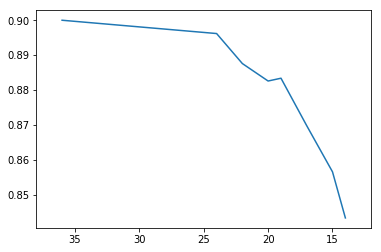

In [79]:
n = []
cv_accuracy = []
for thresh in thresholds:
    # select features using median
    select = SelectFromModel(
        RandomForestClassifier(n_estimators=500, random_state=0),
        threshold=str(thresh)+"*median")

    select.fit(X_traintest_sampled, y_traintest_sampled)
    idxs_selected = select.get_support(indices=True)

    X_traintest_selected = X_traintest_sampled.iloc[:, idxs_selected]
    X_valid_selected = X_valid.iloc[:, idxs_selected]

    # training model
    selection_model = RandomForestClassifier()
    # perform cross-validation
    scores = cross_val_score(selection_model, X_traintest_selected, y_traintest_sampled, cv=5)
     # compute mean cross-validation accuracy
    accuracy = np.mean(scores)    
    cv_accuracy.append(accuracy)
    n.append(X_traintest_selected.shape[1])
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, X_traintest_selected.shape[1], accuracy*100.0))
plt.plot(n, cv_accuracy, label="cv accuracy")
plt.xlim(38, 12)

In [15]:
def feature_selection(thresh, X_traintest_sampled, y_traintest_sampled, X_valid):
    # select features using median
    select = SelectFromModel(
        RandomForestClassifier(n_estimators=500, random_state=0),
        threshold=str(thresh)+"*median")

    select.fit(X_traintest_sampled, y_traintest_sampled)
    idxs_selected = select.get_support(indices=True)

    X_traintest_selected = X_traintest_sampled.iloc[:, idxs_selected]
    X_valid_selected = X_valid.iloc[:, idxs_selected]
    return X_traintest_selected, X_valid_selected

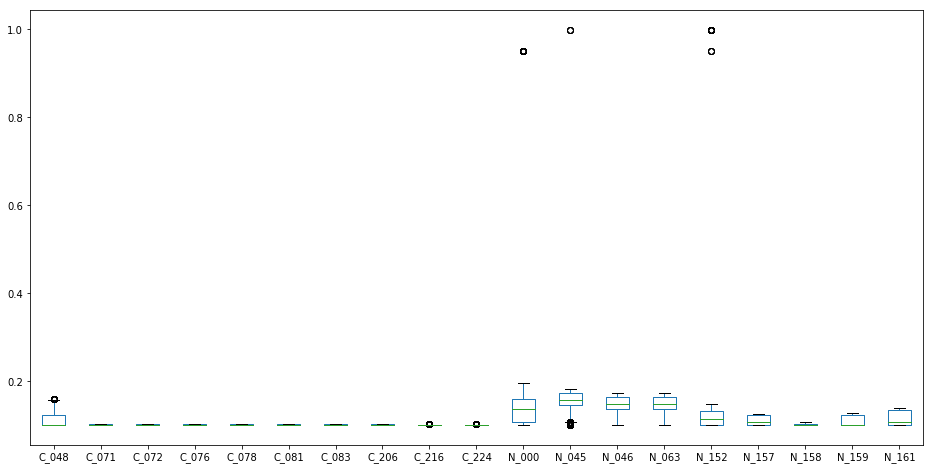

In [16]:
X_traintest_selected, X_valid_selected = feature_selection(10, X_traintest_sampled, y_traintest_sampled, X_valid)
X_traintest_selected.plot.box(figsize=(16,8))

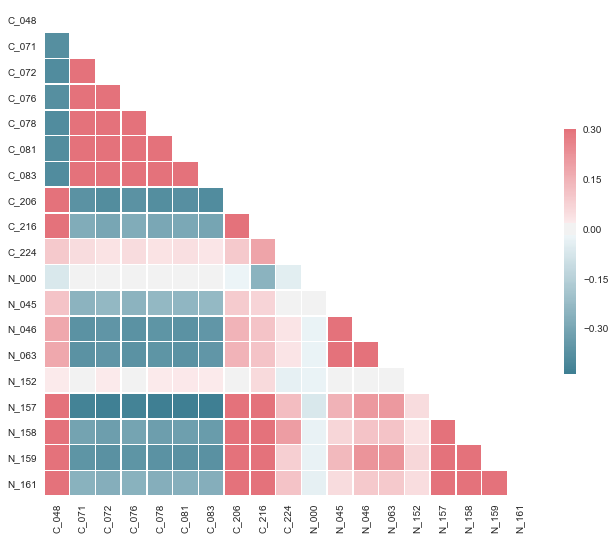

In [79]:
sns.set(style="white")

# Generate a large random dataset
d = pd.DataFrame(data=X_traintest_selected,
                 columns=list(X_traintest_selected))

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [19]:
Mo0 = y_valid.index[y_valid==0].tolist()
Mo1 = y_valid.index[y_valid==1].tolist()
Mo2 = y_valid.index[y_valid==2].tolist()
Mo3 = y_valid.index[y_valid==3].tolist()
Mo9 = y_valid.index[y_valid==4].tolist()

In [17]:
xgb_traintest = xgboost.DMatrix(X_traintest_selected, label=y_traintest_sampled)
xgb_valid = xgboost.DMatrix(X_valid_selected, label=y_valid)

In [114]:
gridsearch_params = [
#     (max_depth, min_child_weight, n_estimators)
#     for max_depth in range(9,12)
#     for min_child_weight in range(5,8)
#     for n_estimators in [100, 200, 500, 1000]
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [115]:
# Define initial best params and MAE
num_boost_round = 999
min_merror = float("Inf")
best_params = None
# for max_depth, min_child_weight, n_estimators in gridsearch_params:
#     print("CV with max_depth={}, min_child_weight={}, n_estimators={}".format(
#                              max_depth,
#                              min_child_weight,
#                              n_estimators))

#     # Update our parameters
#     params['max_depth'] = max_depth
#     params['min_child_weight'] = min_child_weight
#     params['n_estimators'] = n_estimators

for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))

    # Update the parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    
    params['objective'] = 'multi:softmax'
    params['num_class'] = 5
    
    # Run CV
    cv_results = xgboost.cv(
        params,
        xgb_traintest,
        num_boost_round=num_boost_round,
        seed=0,
        nfold=5,
        metrics={'merror'},
        early_stopping_rounds=10
    )

    # Update best Merror
    mean_merror = cv_results['test-merror-mean'].min()
    boost_rounds = cv_results['test-merror-mean'].idxmin()
    print("\tMerror {} for {} rounds".format(mean_merror, boost_rounds))
    if mean_merror < min_merror:
        min_merror = mean_merror
#        best_params = (max_depth, min_child_weight, n_estimators)
#print("Best params: {}, {}, {}, Merror: {}".format(best_params[0], best_params[1], best_params[2], min_merror))

        best_params = (subsample, colsample, n_estimators)

print("Best params: {}, {}, Merror: {}".format(best_params[0], best_params[1], min_merror))

CV with subsample=1.0, colsample=1.0
	Merror 0.08615619999999999 for 31 rounds
CV with subsample=1.0, colsample=0.9
	Merror 0.08695699999999999 for 38 rounds
CV with subsample=1.0, colsample=0.8
	Merror 0.087558 for 41 rounds
CV with subsample=1.0, colsample=0.7
	Merror 0.0845534 for 34 rounds
CV with subsample=0.9, colsample=1.0
	Merror 0.0863562 for 45 rounds
CV with subsample=0.9, colsample=0.9
	Merror 0.090162 for 21 rounds
CV with subsample=0.9, colsample=0.8
	Merror 0.08375160000000001 for 77 rounds
CV with subsample=0.9, colsample=0.7
	Merror 0.0887594 for 25 rounds
CV with subsample=0.8, colsample=1.0
	Merror 0.0903628 for 33 rounds
CV with subsample=0.8, colsample=0.9
	Merror 0.08976200000000001 for 28 rounds
CV with subsample=0.8, colsample=0.8
	Merror 0.0885598 for 31 rounds
CV with subsample=0.8, colsample=0.7
	Merror 0.08996119999999999 for 36 rounds
CV with subsample=0.7, colsample=1.0
	Merror 0.0919662 for 42 rounds
CV with subsample=0.7, colsample=0.9
	Merror 0.08996239

In [116]:
best_params

(0.9, 0.8, 1000)

In [130]:
# use validation set to choose # of trees
params = {'max_depth':20, 'n_estimators':500,
         'objective': 'multi:softmax', 'num_class': 5
}

# params['max_depth'] = 10
# params['min_child_weight'] = 5
# params['n_estimators'] = 100
# params['subsample'] = .9
# params['colsample_bytree'] = .8

In [131]:
xgb = xgboost.train(params, xgb_traintest, 100)

In [132]:
params

{'max_depth': 20,
 'n_estimators': 500,
 'num_class': 5,
 'objective': 'multi:softmax'}

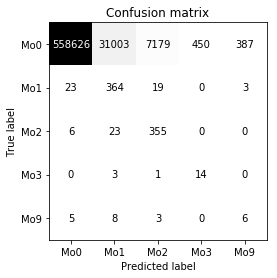

In [134]:
target_names = np.array(le.classes_)
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_valid, xgb.predict(xgb_valid)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [133]:
print("Accuracy score: {:.3f}".format(accuracy_score(y_valid, xgb.predict(xgb_valid))))
print("F1-micro score: {:.3f}".format(f1_score(y_valid, xgb.predict(xgb_valid), average="micro")))
print("F1-weighted score: {:.3f}".format(f1_score(y_valid, xgb.predict(xgb_valid), average="weighted")))
print("Cohen kappa score: {:.3f}".format(cohen_kappa_score(y_valid, xgb.predict(xgb_valid))))

Accuracy score: 0.935
F1-micro score: 0.935
F1-weighted score: 0.965
Cohen kappa score: 0.036


In [27]:
print(classification_report(y_valid, xgb.predict(xgb_valid)))

Cohen kappa score: 0.036
             precision    recall  f1-score   support

          0       1.00      0.93      0.97    597645
          1       0.01      0.89      0.02       409
          2       0.05      0.92      0.09       384
          3       0.03      0.78      0.06        18
          4       0.02      0.27      0.03        22

avg / total       1.00      0.93      0.96    598478



In [54]:
Mo0_sample = X_valid_selected.iloc[Mo0,:].sample(1000, random_state=0)
xgb_valid_Mo0 = xgboost.DMatrix(X_valid_selected.iloc[Mo0,:].loc[Mo0_sample.index], label=y_valid.loc[Mo0_sample.index])
xgb_valid_Mo1 = xgboost.DMatrix(X_valid_selected.iloc[Mo1,:], label=y_valid.loc[Mo1])
xgb_valid_Mo2 = xgboost.DMatrix(X_valid_selected.iloc[Mo2,:], label=y_valid.loc[Mo2])
xgb_valid_Mo3 = xgboost.DMatrix(X_valid_selected.iloc[Mo3,:], label=y_valid.loc[Mo3])
xgb_valid_Mo9 = xgboost.DMatrix(X_valid_selected.iloc[Mo9,:], label=y_valid.loc[Mo9])

In [55]:
shap_values_xgb_Mo0 = xgb.predict(xgb_valid_Mo0, pred_contribs=True)
shap_values_xgb_Mo1 = xgb.predict(xgb_valid_Mo1, pred_contribs=True)
shap_values_xgb_Mo2 = xgb.predict(xgb_valid_Mo2, pred_contribs=True)
shap_values_xgb_Mo3 = xgb.predict(xgb_valid_Mo3, pred_contribs=True)
shap_values_xgb_Mo9 = xgb.predict(xgb_valid_Mo9, pred_contribs=True)

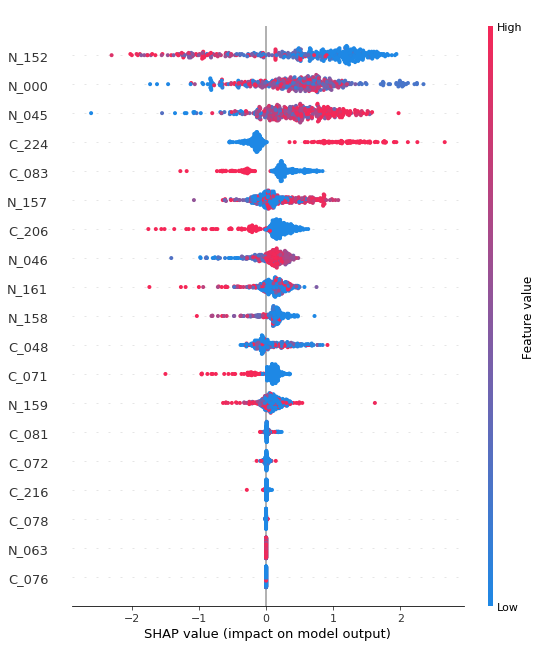

In [56]:
shap.summary_plot(shap_values_xgb_Mo1[:, 1, :], X_valid_selected.iloc[Mo1,:])

In [65]:
i = 5
shap.force_plot(shap_values_xgb_Mo2[:, 2, :][i], X_valid_selected.iloc[Mo2[i],:])

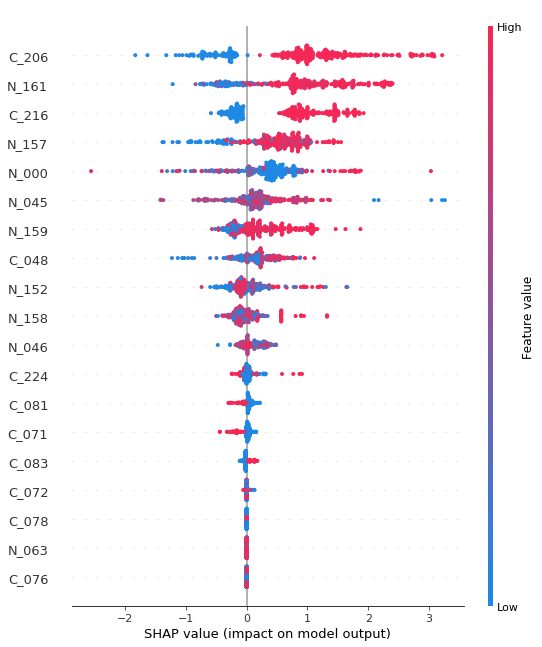

In [57]:
shap.summary_plot(shap_values_xgb_Mo2[:, 2, :], X_valid_selected.iloc[Mo2,:])

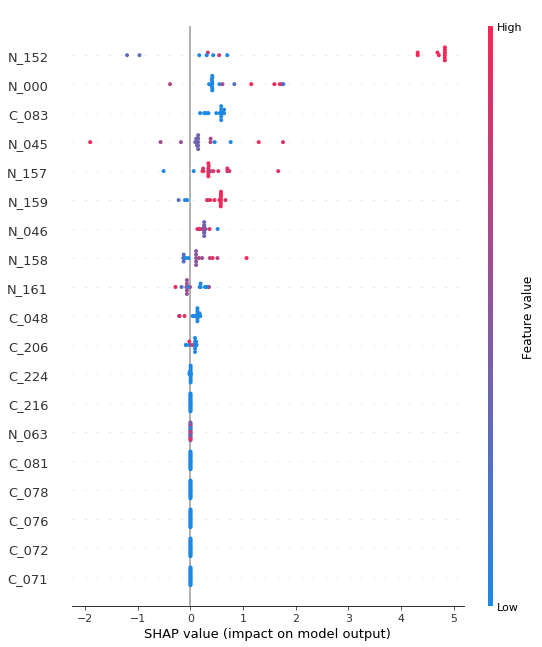

In [58]:
shap.summary_plot(shap_values_xgb_Mo3[:, 3, :], X_valid_selected.iloc[Mo3,:])

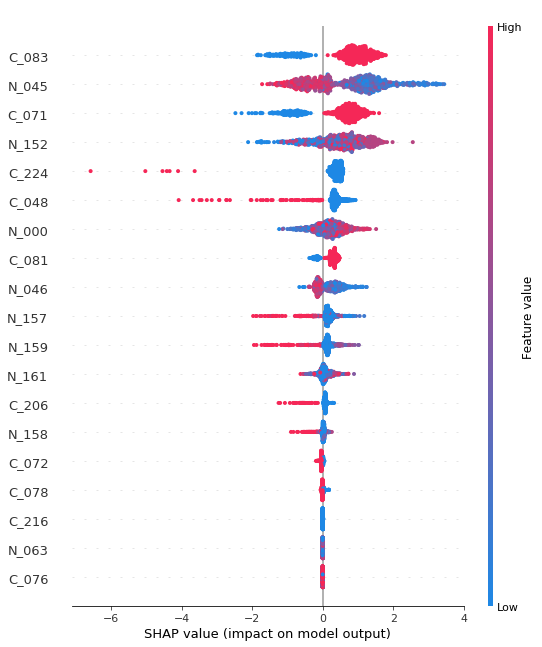

In [59]:
shap.summary_plot(shap_values_xgb_Mo0[:, 0, :], X_valid_selected.iloc[Mo0,:].loc[Mo0_sample.index])

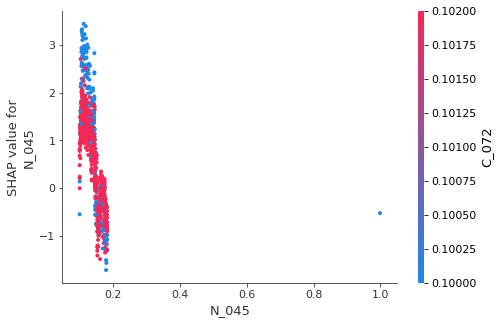

In [61]:
shap.dependence_plot("N_045", shap_values_xgb_Mo0[:, 0, :], X_valid_selected.iloc[Mo0,:].loc[Mo0_sample.index])

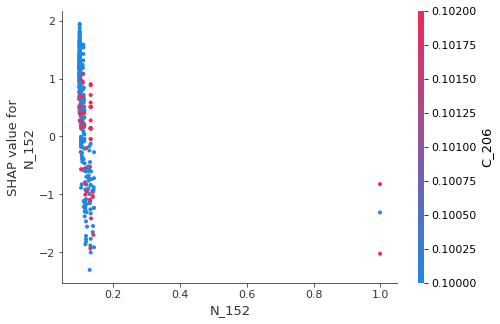

In [62]:
shap.dependence_plot("N_152", shap_values_xgb_Mo1[:, 1, :], X_valid_selected.iloc[Mo1,:])

In [143]:
pipe = pipeline.Pipeline([('preprocessing', None), ('classifier', SVC())])
param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier()], 'preprocessing': [StandardScaler(), None],
     'classifier__n_estimators': [100, 500, 1000],
     'classifier__bootstrap': [True, False],
     'classifier__criterion': ['gini', 'entropy']},
    {'classifier': [KNeighborsClassifier()], 
     'preprocessing': [StandardScaler(), None],
     'classifier__n_neighbors': [3, 5, 10]},
    {'classifier': [GaussianNB()], 'preprocessing': [None]}]
     
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)

grid.fit(X_traintest_selected, y_traintest_sampled)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_valid_selected, y_valid_sampled)))
print("Best parameters: {}".format(grid.best_params_))
# grid.grid_scores_

Best cross-validation accuracy: 0.87
Test set score: 0.87
Best parameters: {'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True), 'classifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), 'classifier__bootstrap': True, 'classifier__criterion': 'gini', 'classifier__n_estimators': 500}


In [146]:
pipe = pipeline.Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(C=100, gamma=0.01, probability=True))])
pipe.fit(X_traintest_selected, y_traintest_sampled)
print("Valid set score: {:.3f}".format(pipe.score(X_valid_selected, y_valid_sampled)))

Test set score: 0.822


In [145]:
rf = RandomForestClassifier(n_estimators=500, criterion = 'gini')
rf.fit(X_traintest_selected, y_traintest_sampled)
print("Valid set score: {:.3f}".format(rf.score(X_valid_selected, y_valid_sampled)))

Test set score: 0.876


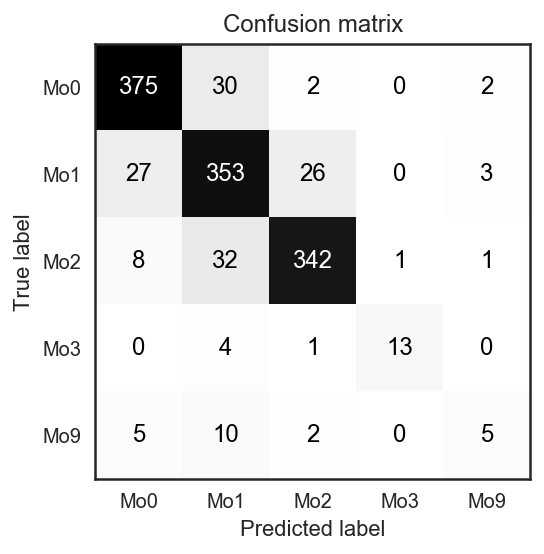

In [147]:
target_names = np.array(le_test.classes_)
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_valid_sampled, rf.predict(X_valid_selected)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

<Container object of 5 artists>

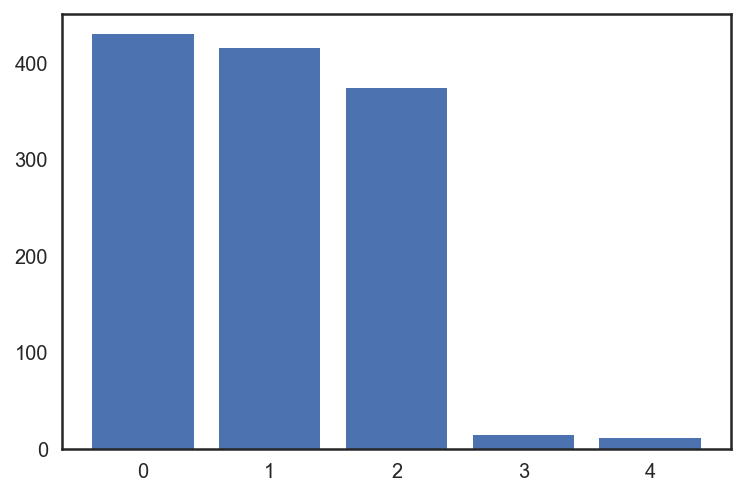

In [149]:
results = pd.DataFrame(rf.predict(X_valid_selected), columns=['predict'])
results['y'] = y_valid_sampled
predicts = results['predict'].value_counts()
plt.bar(range(len(predicts)), predicts)

In [150]:
predicts

1    429
0    415
2    373
3     14
4     11
Name: predict, dtype: int64

In [151]:
Mo0 = results.index[results['y']==0].tolist()
Mo1 = results.index[results['y']==1].tolist()
Mo2 = results.index[results['y']==2].tolist()
Mo3 = results.index[results['y']==3].tolist()
Mo9 = results.index[results['y']==4].tolist()

In [76]:
shap.initjs()

In [153]:
explainer = shap.KernelExplainer(rf.predict_proba, X_valid_selected)

In [154]:
with Timer('SHAP'):
    shap_values_Mo3 = explainer.shap_values(X_valid_selected.iloc[Mo3,:])

100%|██████████| 18/18 [31:27<00:00, 104.85s/it]

[SHAP]
Elapsed: 1887.262834072113


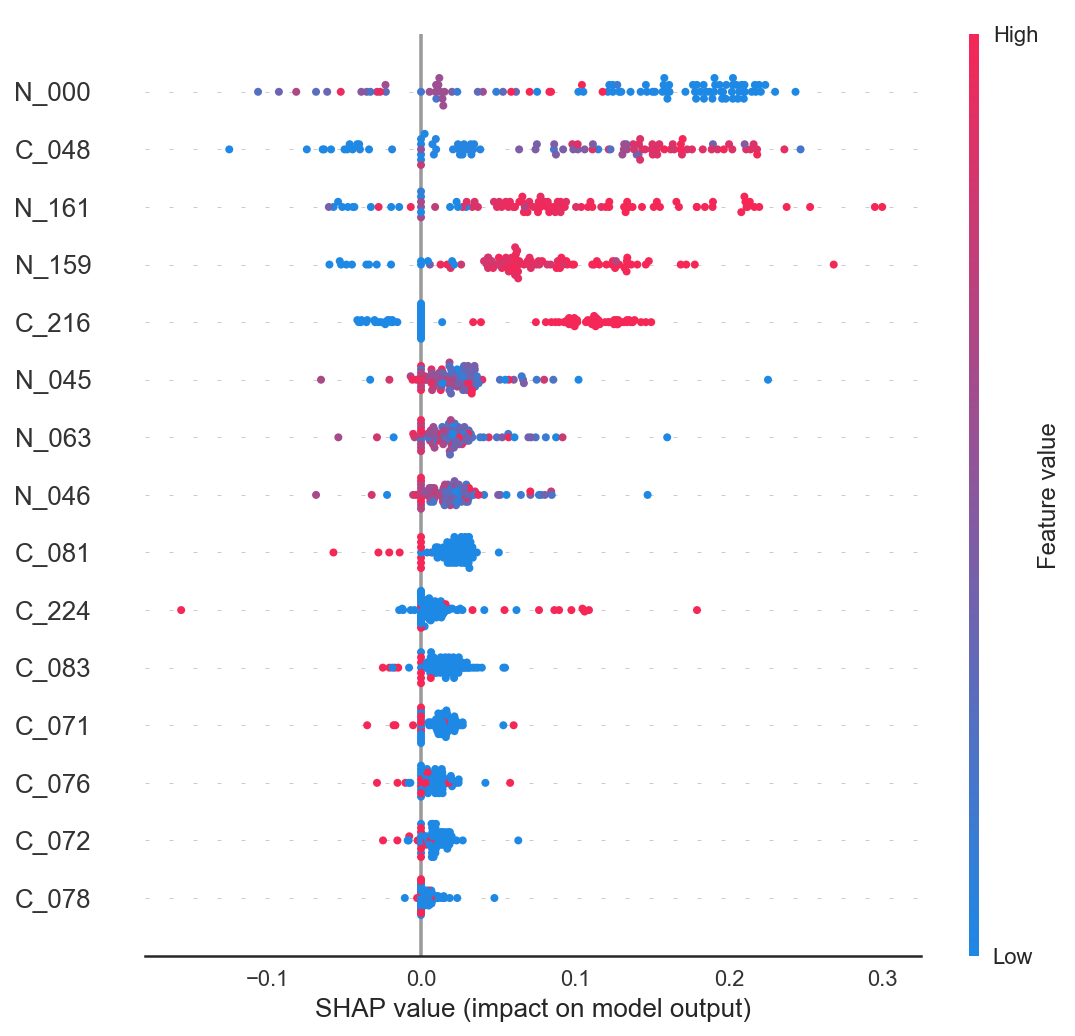

In [237]:
shap.summary_plot(shap_values_Mo2[2], X_valid_selected.iloc[idx_Mo2,:])

In [80]:
# Write the shap values to csv files
for lists, names in zip([shap_values_Mo0, shap_values_Mo1, shap_values_Mo2, shap_values_Mo3, shap_values_Mo9], ["shap_values_Mo0", "shap_values_Mo1", "shap_values_Mo2", "shap_values_Mo3", "shap_values_Mo9"]):#, shap_values_Mo1, shap_values_Mo2, shap_values_Mo3, shap_values_Mo9]:
    test_list = lists
    test_array = np.vstack(test_list)
    test_df = pd.DataFrame(test_array)
    test_df.to_csv("output_cluster_"+names+".csv")
    test_df2 = pd.read_csv("output_cluster_"+names+".csv", index_col=0)
    test_array2 = np.array(test_df2)
    test_list2 = np.split(test_array2, 5)
    print(all([np.allclose(x, y) for x, y in zip(test_list, test_list2)]))#True

True
True
True
True
True


In [85]:
# Read shpa values from csv files
for lists, names in zip([shap_values_Mo0, shap_values_Mo1, shap_values_Mo2, shap_values_Mo3], ["shap_values_Mo0", "shap_values_Mo1", "shap_values_Mo2", "shap_values_Mo3"]):#, shap_values_Mo1, shap_values_Mo2, shap_values_Mo3, shap_values_Mo9]:
    test_df2 = pd.read_csv("output_cluster_"+names+".csv", index_col=0)
    test_array2 = np.array(test_df2)
    test_list2 = np.split(test_array2, 5)
#    print(all([np.allclose(x, y) for x, y in zip(test_list, test_list2)]))#True